## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch
import numpy as np
from torch.nn import Parameter
from matplotlib import pyplot as plt
import seaborn as sns
from os import path

from lafomo.datasets import P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.models import OrdinaryLFM, MultiOutputGP
from lafomo.plot import Plotter
from lafomo.trainer import TranscriptionalTrainer

Let's start by importing our dataset...

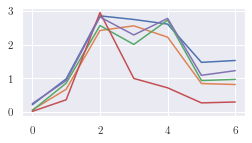

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data')
num_genes = 5
num_tfs = 1

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])

Differential equation here: ....

Since this is an ordinary differential equation (ODE), we inherit from the `OrdinaryLFM` class.

In [3]:
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration):
        super().__init__(num_outputs, gp_model, config)
        self.decay_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.basal_rate = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.sensitivity = Parameter(0.2 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)

        decay = self.decay_rate * h

        f = self.f[:, :, self.t_index].unsqueeze(2)

        h = self.basal_rate + self.sensitivity * f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

In [4]:
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    num_samples=80,
    kernel_scale=False,
    initial_conditions=False
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float32)
step_size = 1e-1

gp_model = MultiOutputGP(inducing_points, num_tfs)
lfm = TranscriptionLFM(num_genes, gp_model, config)
plotter = Plotter(lfm, dataset.gene_names, style='seaborn')

In [5]:
class P53ConstrainedTrainer(TranscriptionalTrainer):
    def extra_constraints(self):
        self.lfm.sensitivity[3] = np.float64(1.)
        self.lfm.decay_rate[3] = np.float64(0.8)

optimizer = torch.optim.Adam(lfm.parameters(), lr=0.03)
trainer = P53ConstrainedTrainer(lfm, optimizer, dataset)

C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\torch\optim\adam.py:48: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


### Outputs prior to training:

C:\Users\Jacob\Documents\proj\lafomo\lafomo\plot\plotter.py:120: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


MultitaskMultivariateNormal(loc: torch.Size([80]))

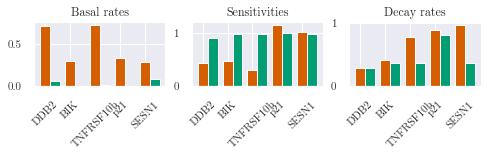

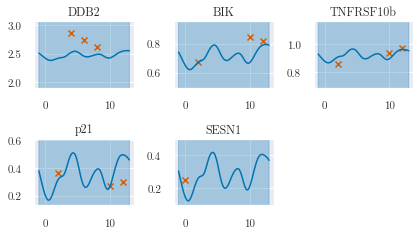

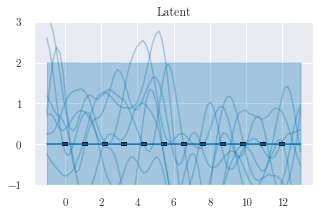

In [6]:
plotter.plot_kinetics()
plotter.plot_outputs(t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                     model_kwargs=dict(step_size=step_size))
plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=False, plot_inducing=False)


In [7]:
lfm.train()

trainer.train(350, report_interval=10, step_size=step_size)



Epoch 001/350 - Loss: 8.86 (8.86 0.00) λ: [0.6733472]
Epoch 011/350 - Loss: 7.17 (7.00 0.17) λ: [0.5945289]
Epoch 021/350 - Loss: 6.47 (6.23 0.23) λ: [0.70741796]
Epoch 031/350 - Loss: 6.03 (5.67 0.37) λ: [0.7719173]
Epoch 041/350 - Loss: 5.50 (5.05 0.45) λ: [0.8923415]
Epoch 051/350 - Loss: 5.04 (4.45 0.58) λ: [0.9537515]
Epoch 061/350 - Loss: 4.59 (3.89 0.70) λ: [0.98578835]
Epoch 071/350 - Loss: 4.13 (3.37 0.76) λ: [1.030276]
Epoch 081/350 - Loss: 3.75 (2.93 0.83) λ: [1.004791]
Epoch 091/350 - Loss: 3.33 (2.45 0.88) λ: [1.0162511]
Epoch 101/350 - Loss: 2.92 (1.99 0.92) λ: [1.0078695]
Epoch 111/350 - Loss: 2.61 (1.64 0.97) λ: [1.0064107]
Epoch 121/350 - Loss: 2.15 (1.10 1.05) λ: [0.9778356]
Epoch 131/350 - Loss: 2.39 (1.35 1.04) λ: [0.9467836]
Epoch 141/350 - Loss: 1.97 (0.88 1.09) λ: [0.9128813]
Epoch 151/350 - Loss: 2.18 (1.03 1.15) λ: [0.9323464]
Epoch 161/350 - Loss: 2.42 (1.26 1.17) λ: [0.910392]
Epoch 171/350 - Loss: 1.67 (0.43 1.24) λ: [0.91256446]
Epoch 181/350 - Loss: 1.57 (

C:\Users\Jacob\Documents\proj\lafomo\lafomo\plot\plotter.py:120: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


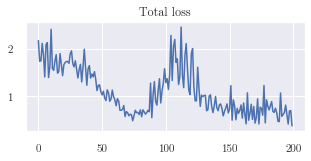

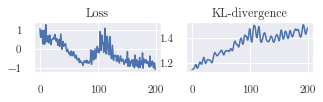

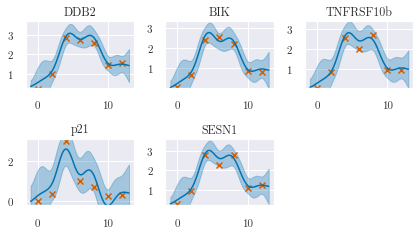

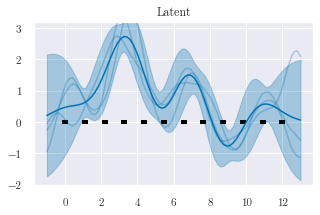

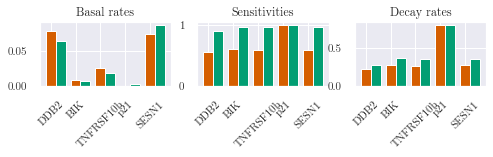

In [8]:
root_dir = '../../../'
experiment_dir = path.join(root_dir, 'experiments/variational')

lfm.eval()
plotter.plot_losses(trainer, last_x=200)
plotter.plot_outputs(t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                     model_kwargs=dict(step_size=step_size))
plt.savefig(path.join(experiment_dir, 'outputs.pdf'), bbox_inches = 'tight', pad_inches = 0)

plotter.plot_latents(t_predict, ylim=(-2, 3.2), plot_barenco=False, plot_inducing=False, num_samples=3)
plt.savefig(path.join(experiment_dir, 'latents.pdf'), bbox_inches = 'tight', pad_inches = 0)

plotter.plot_kinetics()
plt.savefig(path.join(experiment_dir, 'kinetics.pdf'), bbox_inches = 'tight', pad_inches = 0)